# Imports

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

# Silence warnings
import warnings
warnings.filterwarnings('ignore')

# Technical indicators
import talib as ta

# Helper Functions

In [2]:
def getRelativeStockData(ticker, start, end="2024-2-2", interval="1d"):
    data = yf.download(ticker, start=start, end=end, interval=interval)

    # Adding a bunch of technical indicators
    rsi = ta.RSI(data['Close'], timeperiod=14)
    data['RSI'] = rsi

    movingAverage = ta.MA(data['Close'], timeperiod=14)
    data['MovingAverage'] = movingAverage

    upperBand, middleBand, lowerBand = ta.BBANDS(data['Close'], timeperiod=14)
    data['UpperBand'] = upperBand
    data['MiddleBand'] = middleBand
    data['LowerBand'] = lowerBand


    ############################################################
    

    # Making all data til here relative to the previous data point with 1% = 0.01
    # All in a pandas dataframe
    dataRelToPrev = data.pct_change()


    # Fixing the relative dataframe
    dataRelToPrev = dataRelToPrev.dropna()
    dataRelToPrev = dataRelToPrev.reset_index()
    dataRelToPrev = dataRelToPrev.rename(columns={"index": "Date"})

    # Fixing the relative dataframe
    data = data.dropna()
    data = data.reset_index()
    data = data.rename(columns={"index": "Date"})



    # Returns the original data and the relative data
    return data, dataRelToPrev 


def scrollData(originalData, data, contextWindow=10, solutionWindow=3):
    """
    Scroll through the data and return the context window and the solution window for all columns.

    Parameters:
    - data (pandas.DataFrame): The input data.
    - contextWindow (int): The size of the context window.
    - solutionWindow (int): The size of the solution window.

    Returns:
    - scrolledData (pandas.DataFrame): The scrolled data with updated column names.
    """

    # Checking Columns origninally so we can drop em later
    originalColumns = data.columns

    # Create the solution columns only for Close (what to predict)
    # This is before the general loop to make it the first columns
    scrolledDataRel = pd.DataFrame()
    for i in range(solutionWindow):
        scrolledDataRel[f"Solution{'Close'}{i+1}"] = data["Close"].shift(-i)

    # Create the context and solution windows for relToPrev data
    for col in data.columns:
        if col != "Date" and not "Solution" in col:
            # Create the context columns for all columns
            for i in range(contextWindow):
                scrolledDataRel[f"ContextRelPrev{col}{-i}"] = data[col].shift(i)

     # Create the context and solution windows for relToStart data
    scrolledDataAbs = pd.DataFrame()
    for col in originalData.columns:
        if col != "Date" and not "Solution" in col and not "Context" in col:
            # Create the context columns for all columns
            for i in range(contextWindow):
                scrolledDataAbs[f"ContextRelStart{col}{-i}"] = originalData[col].shift(i)
            
            for i in range(contextWindow):
                # Making each column relative to the start
                scrolledDataAbs[f"ContextRelStart{col}{-i}"] = scrolledDataAbs[f"ContextRelStart{col}{-i}"] / scrolledDataAbs[f"ContextRelStart{col}{-contextWindow+1}"] -1

    # Combine the two dataframes
    scrolledData = pd.concat([scrolledDataRel, scrolledDataAbs], axis=1)

    # Drop the NaN values
    scrolledData = scrolledData.dropna()

    # Fix the index
    scrolledData = scrolledData.reset_index(drop=True)

    return scrolledData


def unrelativizeDataArray(data):
    # Unrelativize the data
    # This is done by multiplying the previous data point with the current data point
    # This is done for all values except the first

    processedData = data.copy()

    # Its an array in an array for some reason (with predictions)
    if len(processedData) == 1:
        processedData = processedData[0]

    # Make the base (first value) 0
    processedData[0] = 0

    # Loop through the data and unrelativize it
    for i in range(len(processedData)):
        if i != 0:
            processedData[i] = (processedData[i] + 1) * (processedData[i-1] + 1) - 1

    return processedData


# TODO: Give the training data market context via this function
# def getRelativeStockDataWithContext(ticker, marketContextTickers, start, end="2024-2-2", interval="1d", contextWindow=10, solutionWindow=3):
#     # This function will get the relative stock data 
#     # and then append the context columns for each market context ticker
#     # 
    

Testing if preparation is working

In [3]:
originalData, relativeData = getRelativeStockData('AAPL', '2020-01-01')
# scrollData(originalData, relativeData, contextWindow=500, solutionWindow=100)
relativeData

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume,RSI,MovingAverage,UpperBand,MiddleBand,LowerBand
0,2020-01-24,0.007329,0.011797,0.005924,-0.002882,-0.002882,0.402650,-0.022471,0.004803,0.000236,0.004803,0.009834
1,2020-01-27,-0.031819,-0.035753,-0.039808,-0.029405,-0.029405,0.105109,-0.197564,0.002095,-0.002993,0.002095,0.007646
2,2020-01-28,0.008192,0.021266,0.023977,0.028289,0.028289,0.001815,0.128122,0.004409,-0.004276,0.004409,0.013786
3,2020-01-29,0.037908,0.029680,0.029437,0.020932,0.020932,0.332823,0.068353,0.004811,0.002498,0.004811,0.007263
4,2020-01-30,-0.012051,-0.011469,-0.008183,-0.001449,-0.001449,-0.413848,-0.009019,0.003223,0.004141,0.003223,0.002255
...,...,...,...,...,...,...,...,...,...,...,...,...
1008,2024-01-26,-0.004866,-0.007694,-0.006059,-0.009013,-0.009013,-0.186569,-0.073980,0.004268,0.000924,0.004268,0.007958
1009,2024-01-29,-0.011633,-0.013144,-0.012296,-0.003586,-0.003586,0.057218,-0.030456,0.002333,0.001703,0.002333,0.003023
1010,2024-01-30,-0.005573,-0.002081,-0.011130,-0.019246,-0.019246,0.184827,-0.149229,0.001094,-0.000392,0.001094,0.002720
1011,2024-01-31,-0.020425,-0.024505,-0.016643,-0.019358,-0.019358,-0.007010,-0.136837,-0.000674,0.000654,-0.000674,-0.002124


# Prepare Data

In [4]:
# Some Parameters
contextWindow=500
solutionWindow=100

stocksForData = ["AAPL", "MSFT", "GOOGL", "AMZN", "IBM", "TSLA", "NFLX", 
    "NVDA", "INTC", 'GOLLQ', 'GSK', 'NWG', 'BIRK', 'IHG', 'TAK', 'BAC', 'BK', 'CWK', 'CI', 
    'STT', 'JPM', 'WASH', 'CL', 'WLY', 'HIG', 'C', 'YORW', 'BMO', 'FISI', 
    'BG', 'EBC', 'RBGLY', 'MO', 'KEY', 'WTW', 'CFG', 'M', 'BNS', 'ROG', 
    'MCK', 'IFF', 'CHMG', 'NABZY', 'ONB', 'HIFS', 'TMP', 'PG', 'DE', 
    'BRK.B', 'PFS', 'ADX', 'DNB', 'RYI', 'SWK', 'TRC', 'PSO', 'BC', 'CHD', 
    'BHLB', 'SIEGY', 'FNF', 'AGR', 'CLF', 'PUK', 'UNM', 'LAZ', 'PFE', 
    'ESLOY', 'CMA', 'DCO', 'AXP', 'CCU', 'MATW', 'BHP', 'TRI', 'GLW', 
    'NYT', 'DOLE', 'AROW', 'CMTV', 'WFC', 'PNC', 'THG', 'SWBI', 'BHRB', 
    'TRV', 'OTIS', 'CNA', 'VIVHY', 'LEVI', 'BLCO', 'NVRI', 'WNEB', 'TD', 
    'CR', 'CXT', 'MGEE', 'MTB', 'SNN', 'NBTB', 'SAN', 'BBVA', 'SR', 'B', 
    'ACNB', 'ITOCY', 'MARUY', 'FITB', 'FHB']

# Main Loop for getting more data in form of rows
for stockTicker in stocksForData:
    
    # Get Data for the stock
    originalStockData, relativeStockData = getRelativeStockData(stockTicker, start="2020-1-1", interval="1d") # Gets the max data available

    # Check if enough Data available
    if len(relativeStockData) < contextWindow + solutionWindow:
        print(f"Skipping {stockTicker} because there is not enough data")
        continue

    # Scroll the data
    stockData = scrollData(originalStockData, relativeStockData, contextWindow=contextWindow, solutionWindow=solutionWindow)

    # Add the data to the main data
    if stockTicker == stocksForData[0]:
        data = stockData
    else:
        data = pd.concat([data, stockData], ignore_index=True)


    print(f"Getting Data for {stockTicker}")
    print(f"This one has {len(stockData)} rows")
    print(f"Total rows til now: {len(data)}")

[*********************100%***********************]  1 of 1 completed
Getting Data for AAPL
This one has 415 rows
Total rows til now: 415
[*********************100%***********************]  1 of 1 completed
Getting Data for MSFT
This one has 415 rows
Total rows til now: 830
[*********************100%***********************]  1 of 1 completed
Getting Data for GOOGL
This one has 415 rows
Total rows til now: 1245
[*********************100%***********************]  1 of 1 completed
Getting Data for AMZN
This one has 415 rows
Total rows til now: 1660
[*********************100%***********************]  1 of 1 completed
Getting Data for IBM
This one has 415 rows
Total rows til now: 2075
[*********************100%***********************]  1 of 1 completed
Getting Data for TSLA
This one has 415 rows
Total rows til now: 2490
[*********************100%***********************]  1 of 1 completed
Getting Data for NFLX
This one has 415 rows
Total rows til now: 2905
[*********************100%**********

KeyboardInterrupt: 

In [5]:
# Remove any inf values
data = data.replace([np.inf, -np.inf], np.nan).dropna()

# Split the data into training and testing data
train, test = train_test_split(data, test_size=0.1)

# Columns for the context and solution windows
contextColumns = data.columns[solutionWindow:]
solutionColumns = data.columns[:solutionWindow]

# Split X and y
X_train = train[contextColumns]
y_train = train[solutionColumns]

X_test = test[contextColumns]
y_test = test[solutionColumns]

Statement how the data is looking

In [6]:
print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)

Training data shape: (3361, 11000)
Testing data shape: (374, 11000)


# Train the Model

In [8]:
# Making the MLP model
# model = MLPRegressor(hidden_layer_sizes=(1), max_iter=100, verbose=True)
model = MLPRegressor(hidden_layer_sizes=(250, 50, 250, 10), activation='relu', solver='adam', alpha=0.0001, learning_rate='adaptive', learning_rate_init=0.0005, verbose=True, tol=0.000000001, max_iter=500)



# Train the model
model.fit(X_train, y_train)

Iteration 1, loss = 0.00914681
Iteration 2, loss = 0.00796909
Iteration 3, loss = 0.00709187
Iteration 4, loss = 0.00625566
Iteration 5, loss = 0.00571308
Iteration 6, loss = 0.00501153
Iteration 7, loss = 0.00439361
Iteration 8, loss = 0.00386345
Iteration 9, loss = 0.00338145
Iteration 10, loss = 0.00295431
Iteration 11, loss = 0.00255757
Iteration 12, loss = 0.00237891
Iteration 13, loss = 0.00213189
Iteration 14, loss = 0.00192276
Iteration 15, loss = 0.00174743
Iteration 16, loss = 0.00159061
Iteration 17, loss = 0.00145008
Iteration 18, loss = 0.00131717
Iteration 19, loss = 0.00119825
Iteration 20, loss = 0.00109963
Iteration 21, loss = 0.00121220
Iteration 22, loss = 0.00108030
Iteration 23, loss = 0.00104329
Iteration 24, loss = 0.00107739
Iteration 25, loss = 0.00100067
Iteration 26, loss = 0.00094016
Iteration 27, loss = 0.00089027
Iteration 28, loss = 0.00084521


MLPRegressor(hidden_layer_sizes=(250, 50, 250, 10), learning_rate='adaptive',
             learning_rate_init=0.0005, max_iter=500, tol=1e-09, verbose=True)

# Test the Model

[*********************100%***********************]  1 of 1 completed


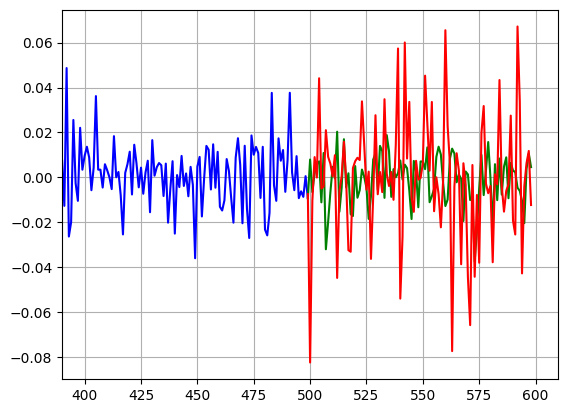

In [16]:
# Get data for Stock
originalData, relativeData = getRelativeStockData("FE", start="2020-1-1", interval="1d")

# Scroll the data
data = scrollData(originalData, relativeData, contextWindow=contextWindow, solutionWindow=solutionWindow)


# Get the x'th data point for testing
whereToPredict = 100 # points before end
contextToPredict = data[contextColumns][-1-whereToPredict:-whereToPredict]
solutionToPredict = data[solutionColumns][-1-whereToPredict:-whereToPredict]

# Make Prediction on that data point
predicitons = model.predict(contextToPredict)


# Make the data usefull (reversing etc.)
plottedContext = contextToPredict.iloc[:, 3*contextWindow:4*contextWindow].values[0][::-1].reshape(-1, 1)
plottedSolution = solutionToPredict.values.reshape(-1, 1)
plottedPredictions = predicitons.reshape(-1, 1)

# Plot the data in green, red, blue
plt.plot(plottedContext, "blue")

x_values = range(contextWindow - 1, contextWindow + len(plottedSolution) - 1)
plt.plot(x_values, plottedSolution, "green")

x_values = range(contextWindow-1, contextWindow + len(plottedPredictions)-1)
plt.plot(x_values, plottedPredictions, "red")

# Set the x-axis range to zoom from ... to ...
plt.xlim(len(unrelativizeDataArray(plottedContext))-len(unrelativizeDataArray(plottedPredictions))*1.1, len(unrelativizeDataArray(plottedContext)) + len(unrelativizeDataArray(plottedPredictions)) * 1.1)

plt.grid()

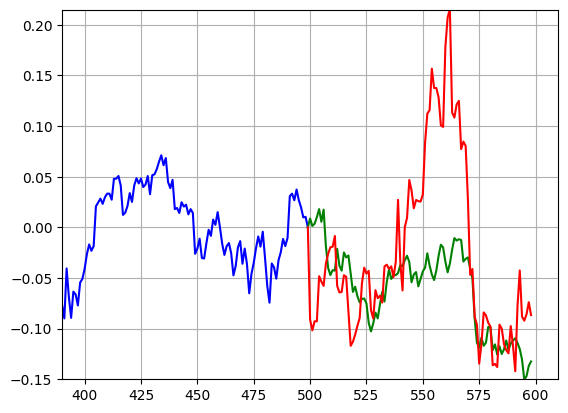

In [17]:
# Plot the data in green, red, blue
plt.plot(unrelativizeDataArray(plottedContext) - unrelativizeDataArray(plottedContext)[-1], "blue")

x_values = range(contextWindow - 1, contextWindow + len(plottedSolution) - 1)
y_values = unrelativizeDataArray(plottedSolution) * (unrelativizeDataArray(plottedContext)[-1] + 1)
plt.plot(x_values, y_values , "green")

x_values = range(contextWindow-1, contextWindow + len(plottedPredictions)-1)
y_values = unrelativizeDataArray(plottedPredictions) * (unrelativizeDataArray(plottedContext)[-1] + 1)
plt.plot(x_values, y_values, "red")

# Set the x-axis range to zoom from ... to ...
xlim = len(unrelativizeDataArray(plottedContext))-len(unrelativizeDataArray(plottedPredictions))*1.1, len(unrelativizeDataArray(plottedContext)) + len(unrelativizeDataArray(plottedPredictions)) * 1.1
plt.xlim(xlim)

# Set the y-axis range to zoom from the minimum to the maximum of all values visible in the plot
allValuesInPlot = np.append(unrelativizeDataArray(plottedPredictions), unrelativizeDataArray(plottedSolution))
allValuesInPlot = np.append(allValuesInPlot, (unrelativizeDataArray(plottedContext) - unrelativizeDataArray(plottedContext)[-1])[int(xlim[0]):int(xlim[1])])

plt.ylim(min(allValuesInPlot)*1.1, max(allValuesInPlot)*1.1)

plt.grid()

# Calculating some fancy stats

In [18]:
# Average percent error calculation
# First we'll calculate the percentage error between all the predictions and the actual values
# Then we'll calculate the average of those percentage errors

# Average absolute error calculation
# First we'll calculate the absolute error between all the predictions and the actual values
# Then we'll calculate the average of those absolute errors

avgPercentErrors = []
avgAbsoluteErrors = []


for i in range(len(plottedPredictions)):
    percentError = abs(plottedPredictions[i] / plottedSolution[i]) # 1% = 0.01
    avgPercentErrors.append(percentError)

    absoluteError = abs(plottedPredictions[i] - plottedSolution[i])
    avgAbsoluteErrors.append(absoluteError)

In [19]:
avgPercentErrors = pd.DataFrame(avgPercentErrors)
avgPercentErrors = avgPercentErrors.replace([np.inf, -np.inf], np.nan).dropna()

# Calculate the average of the errors
avgPercentError = sum(avgPercentErrors[0]) / len(avgPercentErrors)
avgAbsoluteError = (sum(avgAbsoluteErrors) / len(avgAbsoluteErrors))[0]

In [20]:
# Sum up with print statements
print(f"Average percent error: {round(avgPercentError*100, 2)}%")
print(f"Average absolute error: {round(avgAbsoluteError*100, 2)}%")

Average percent error: 490.25%
Average absolute error: 2.14%


# Some actually professional measures

In [21]:
# Predict the Testing Data
predicitons = model.predict(X_test)

# Calculate the mean squared error
mse = mean_squared_error(y_test, predicitons)

# Print the mean squared error
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.0013002676244767103
